In [2]:
from manim import *
from numpy import linalg as npl
import matplotlib.pyplot as plt
import jupyter_capture_output
from scipy.interpolate import make_interp_spline, BSpline

video_scene = " -v WARNING --progress_bar None --disable_caching moi_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s moi_Scene"

Manim Community v0.16.0.post0

Jupyter Capture Output v0.0.6


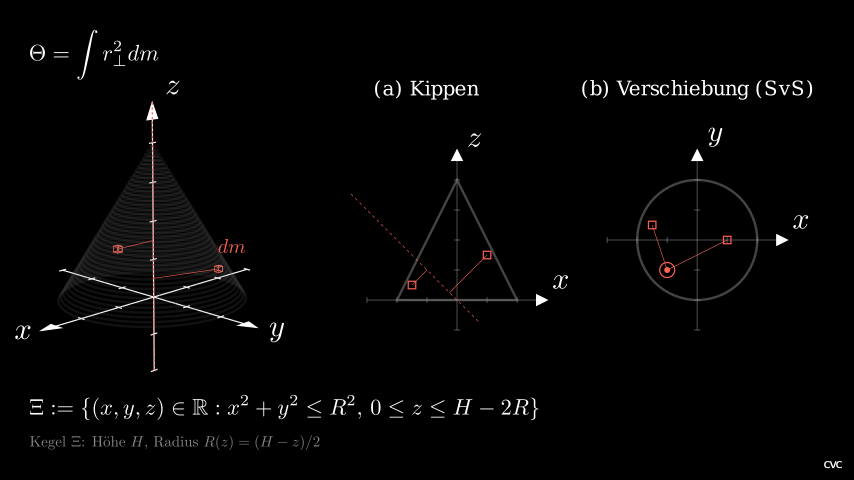

In [108]:
%%capture_video --path "animations/moment_of_inertia/moment_of_inertia.mp4"
%%manim -ql --fps 20 $video_scene

class moi_Scene(ThreeDScene):
    def construct(self):
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)


        # Equations
        moi_eq1 = MathTex(r'\Theta=\int r_{\perp}^2 dm', font_size = 36).align_on_border(UP + LEFT, buff = 0.5)
        moi_eq2 = MathTex(r'\Theta=\varrho\int_V r_{\perp}^2 dV', font_size = 36).align_on_border(UP + LEFT, buff = 0.5)
        moi_eq3 = MathTex(r'\mathrm{mit}~\varrho=const.=\frac{m}{V}', font_size = 36, color = BLUE).next_to(moi_eq2, 2*RIGHT)     

        cone_eq1 = MathTex(r'\Xi:=\{(x, y, z)\in\mathbb{R}:x^2+y^2\leq R^2,\,0\leq z\leq H-2R\}', font_size = 36).align_on_border(LEFT + DOWN).shift(0.5*UP)
        cone_eq2 = Tex(r'$\mathrm{Kegel}$ $\Xi$: Höhe $H$, Radius $R(z)=(H-z)/2$', font_size = 24, color = GREY).align_on_border(LEFT + DOWN)


        # 3D-Coordinate System
        CO3D = [-6, 0, -6]
        ax = ThreeDAxes(
            x_range = (-3, 3, 1), y_range = (-3, 3, 1), z_range = (-2, 5, 1),
            x_length = 6, y_length = 6, z_length = 6, axis_config = {'tip_length': 0.05, 'tip_width': 0.3}, 
            z_axis_config = {'color': WHITE},
            ).move_to(CO3D).rotate(
                axis = [1, 0, 0], angle = 6*PI/4
                ).rotate(
                    axis = [0, 1, 0], angle = 5*PI/4
                    ).rotate(axis = [1, 0, 0], angle = PI/12).rotate(
                        axis = [0, 1, 0], angle = PI/16
                        )

        x_lab = Tex('$x$', font_size = 64).move_to(CO3D).shift(2*DOWN + 2.75*LEFT)
        y_lab = Tex('$y$', font_size = 64).move_to(CO3D).shift(2*DOWN + 2.75*RIGHT)
        z_lab = Tex('$z$', font_size = 64).move_to(CO3D + 0.5*RIGHT).shift(3.3*UP)
        ax_3D = VGroup(ax, x_lab, y_lab, z_lab)

        # Axis of rotation
        def aor(phi, x_shift, y_shift):
            return DashedLine(ax.c2p(2*np.sin(phi) + x_shift, y_shift, -2*np.cos(phi)), ax.c2p(x_shift - 5*np.sin(phi), y_shift, 5*np.cos(phi)), color = RED, stroke_width = 2)

        ax_aor = aor(0, 0, 0)

        # Cone
        def cone_circ(z):
            r = (4 - z) / 2
            return ax.plot_parametric_curve(lambda phi: np.array([r*np.cos(phi), r*np.sin(phi), z]), t_range = [0, 2*PI], stroke_opacity = 0.125, color = GREY)

        cone_circ_list = [cone_circ(z) for z in np.arange(0, 4.01, 0.1)]

        # Mass-Elements
        def cone_cube(pos):
            x, y, z = pos[0], pos[1], pos[2]
            dm_cube = Cube(side_length = 0.125, fill_opacity = 0, color = RED, stroke_width = 1).rotate(
                    axis = [1, 0, 0], angle = 6*PI/4
                    ).rotate(
                        axis = [0, 1, 0], angle = 5*PI/4
                        ).rotate(axis = [1, 0, 0], angle = PI/12).rotate(
                            axis = [0, 1, 0], angle = PI/16
                            ).move_to(ax.coords_to_point(x, y, z))
            dm_radius = Line(start = ax.c2p(x, y, z), end = ax_aor.get_projection(dm_cube.get_center()), color = RED, stroke_width = 1)
            dm = VGroup(dm_cube, dm_radius)
            dV_cube = Cube(side_length = 0.125, fill_opacity = 0, color = BLUE, stroke_width = 1).rotate(
                    axis = [1, 0, 0], angle = 6*PI/4
                    ).rotate(
                        axis = [0, 1, 0], angle = 5*PI/4
                        ).rotate(axis = [1, 0, 0], angle = PI/12).rotate(
                            axis = [0, 1, 0], angle = PI/16
                            ).move_to(ax.coords_to_point(x, y, z))
            dV_radius = Line(start = ax.c2p(x, y, z), end = ax_aor.get_projection(dm_cube.get_center()), color = RED, stroke_width = 1)
            dV = VGroup(dV_cube, dV_radius)
            return dm, dV


        cc1 = (-3/2, 1/2, 0.5)
        cc2 = (1, 0, 1.5)

        dm_eq = MathTex(r'dm', color = RED, font_size = 32).move_to([-3.25, -0.1, 0])
        dV_eq = MathTex(r'dV', color = BLUE, font_size = 32).move_to([-3.25, -0.1, 0])


        # 2D-Coordinate Systems
        ax1 = Axes(x_range = [-3, 3, 1], y_range = [-3, 3, 1], x_length = 6, y_length = 6, axis_config = {"stroke_opacity": 0.25}).move_to([4.5, -0, 0]).scale(0.5)
        ax1_head = Text('(b) Verschiebung (SvS)', font_size = 24).move_to([4.5, 2.5, 0])
        ax1_x_lab = ax1.get_x_axis_label('x')
        ax1_y_lab = ax1.get_y_axis_label('y')   

        ax2 = Axes(x_range = [-3, 3, 1], y_range = [-1, 5, 1], x_length = 6, y_length = 6, axis_config = {"stroke_opacity": 0.25}).move_to([0.5, -0, 0]).scale(0.5)
        ax2_head = Text('(a) Kippen', font_size = 24).move_to([0, 2.5, 0])
        ax2_x_lab = ax2.get_x_axis_label('x')
        ax2_y_lab = ax2.get_y_axis_label('z') 
                      

        def aor1(x_shift, y_shift):
            circ = Circle(radius = 0.125, color = RED, stroke_width = 2)
            dot = Dot(radius = 0.05, color = RED)
            return VGroup(circ, dot).move_to(ax1.c2p(x_shift, y_shift, 1))

        ax1_aor = aor1(-1, -1)
        ax1_cone = Circle.from_three_points(ax1.c2p(-2, 0, 0), ax1.c2p(0, 2, 0), ax1.c2p(2, 0, 0), color = GREY, stroke_opacity = 0.5)
        ax1_cc1 = Square(side_length = 0.125, stroke_color = RED, stroke_width = 2).move_to(ax1.c2p(cc1[0], cc1[1], 0))
        ax1_cc1_proj = Line(start = ax1.c2p(cc1[0], cc1[1], 0), end = ax1_aor.get_center(), color = RED, stroke_width = 1) 
        ax1_cc2 = Square(side_length = 0.125, stroke_color = RED, stroke_width = 2).move_to(ax1.c2p(cc2[0], cc2[1], 0))
        ax1_cc2_proj = Line(start = ax1.c2p(cc2[0], cc2[1], 0), end = ax1_aor.get_center(), color = RED, stroke_width = 1)

        def aor2(phi, x_shift):
            return DashedLine(ax2.c2p(np.sin(phi) + x_shift, -np.cos(phi), 1), ax2.c2p(x_shift - 5*np.sin(phi), 5*np.cos(phi), 1), color = RED, stroke_width = 1)

        ax2_aor = aor2(PI/4, 0)
        ax2_cone = Polygon(ax2.c2p(-2, 0, 0), ax2.c2p(0, 4, 0), ax2.c2p(2, 0, 0), color = GREY, stroke_opacity = 0.5)
        ax2_cc1 = Square(side_length = 0.125, stroke_color = RED, stroke_width = 2).move_to(ax2.c2p(cc1[0], cc1[2], 0))
        ax2_cc1_proj = Line(start = ax2.c2p(cc1[0], cc1[2], 0), end = ax2_aor.get_projection(ax2_cc1.get_center()), color = RED, stroke_width = 1) 
        ax2_cc2 = Square(side_length = 0.125, stroke_color = RED, stroke_width = 2).move_to(ax2.c2p(cc2[0], cc2[2], 0))
        ax2_cc2_proj = Line(start = ax2.c2p(cc2[0], cc2[2], 0), end = ax2_aor.get_projection(ax2_cc2.get_center()), color = RED, stroke_width = 1) 

        ax1_group = VGroup(ax1, ax1_head, ax1_cone, ax1_x_lab, ax1_y_lab, ax1_aor, ax1_cc1, ax1_cc2, ax1_cc1_proj, ax1_cc2_proj)
        ax2_group = VGroup(ax2, ax2_head, ax2_cone, ax2_x_lab, ax2_y_lab, ax2_aor, ax2_cc1, ax2_cc2, ax2_cc1_proj, ax2_cc2_proj)

        # self.wait(0.5)
        # self.play(Create(cone_cube1[0]), run_time = 1.5)
        # self.play(Create(cone_cube2[0]), run_time = 1.5)
        # self.wait(0.5)
        # self.play(Write(moi_eq3))
        # self.wait(0.5)
        # self.play(Transform(moi_eq1, moi_eq2), Transform(cone_cube(cc1)[0], cone_cube(cc1))[1]), Transform(cone_cube(cc2))[0], cone_cube(cc2))[1]), run_time = 1.5)
        # self.wait(0.5)
        # self.play(Uncreate(moi_eq3))
        # self.wait(3)

        self.add(moi_eq1)
        self.add(cone_eq1, cone_eq2)
        self.add(ax_3D)
                
        for cone_circ_i in cone_circ_list:
        #    self.wait(0.05)
            self.add(cone_circ_i)


        self.add(cone_cube(cc1)[0], cone_cube(cc2)[0])
        self.add(dm_eq, ax_aor)
        self.add(ax1_group, ax2_group)
            